# Freedman's paradox

In this notebook, we study Freedman's paradox. It is a simple paradox, where we perfrom adaptive feature selection. At each step of the procedure, we are selecting "better" features, but end up having a worse model. 

This is one of the reasons why feature selection, and any other "data cleaning" procedure might lead to biased results. The problem already appears when we want to fit independent features to a given dependent feature. However, it is much worse when we simply want to discover relationships between features. To see this, note that feature selection for a linear regression problem amounts to answering the question 'which of the n input features are related to the 1 output feature?'. So we need to test $O(n)$ relationships. In the more general setting, we are asking 'which features are related to which other features?'. There we have $O(n^2)$ opportunities to make a mistake!

Let us walk through this example.


In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# This example makes sense only when the number of featues is of the same order as the number of data points.
n_features = 1000
n_data = 2 * n_features

In [3]:
# Here everything is normally distributed, with none of the features predictive of y
X = np.random.normal(size=[n_data, n_features])
y = np.random.normal(size=n_data) + np.mean(np.ones(10)*X[:,0:10],1)
X_eval = np.random.normal(size=[n_data, n_features])
y_eval = np.random.normal(size=n_data) + np.mean(np.ones(10)*X[:,0:10],1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)


## Regression on the standard featues

We can perform regression on the standard features, keeping only those features with low p-value.

Since our features have been selected under the null hypothesis, this means that approximately 10% of the features will have a p-value <0.1. That is how p-values are by construction.

In the example below, we select 25% of the 'best' features, while also counting the number of features with p-value < 0.05. After keeping the best features, we then refit on them. How do the p-values of the those features look like after refitting?


p < 0.25: 254
p < 0.05: 49
[1.76493810e-02 1.65286288e-03 2.84917792e-02 4.93142137e-01
 1.87673812e-01 6.51773453e-03 1.63168237e-02 1.16087964e-01
 1.93540135e-01 2.62831772e-03 1.12127248e-01 5.07979061e-01
 3.24001142e-01 5.48031390e-01 5.33689591e-01 8.56251017e-01
 4.74360210e-01 2.79369063e-01 1.69650354e-01 9.53624348e-01
 6.75092856e-01 6.06939658e-01 7.63629292e-01 6.25076813e-01
 6.59647698e-01 2.84131998e-01 1.08038770e-01 9.05258810e-01
 9.55335070e-01 9.74446331e-01 1.69814738e-01 5.11317716e-01
 3.21664434e-01 6.42143480e-01 7.76032488e-01 1.28911058e-01
 6.54428968e-01 2.69150409e-01 7.34645376e-01 5.28037036e-01
 9.01294089e-01 1.73907770e-01 3.35896322e-01 9.37442027e-01
 2.78045344e-01 8.54083182e-02 1.91273870e-02 5.51624081e-01
 1.79455297e-01 9.81547252e-01 1.24302758e-01 6.86529354e-01
 7.89890036e-01 6.29207322e-02 7.90839752e-01 4.41668660e-01
 7.65381001e-01 7.36236764e-01 5.56044212e-01 1.49442553e-01
 9.43562724e-01 4.68245616e-01 6.55384665e-01 7.14160604e-

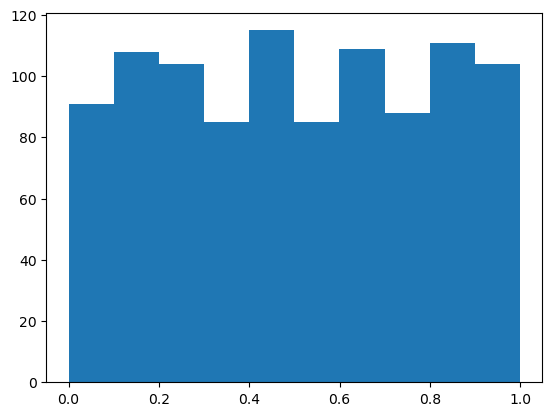

In [5]:
# The same, with SM
import statsmodels.api as sm
results = sm.OLS(y_train, X_train).fit()
results.summary()
print("p < 0.25:", sum(results.pvalues < 0.25))
print("p < 0.05:", sum(results.pvalues < 0.05))
plt.hist(results.pvalues)
print(results.pvalues)

p < 0.25: 202
p < 0.05: 118


(array([153.,  29.,  26.,   9.,  12.,  11.,   6.,   4.,   1.,   3.]),
 array([1.30983479e-08, 9.58021888e-02, 1.91604365e-01, 2.87406540e-01,
        3.83208716e-01, 4.79010892e-01, 5.74813067e-01, 6.70615243e-01,
        7.66417419e-01, 8.62219595e-01, 9.58021770e-01]),
 <BarContainer object of 10 artists>)

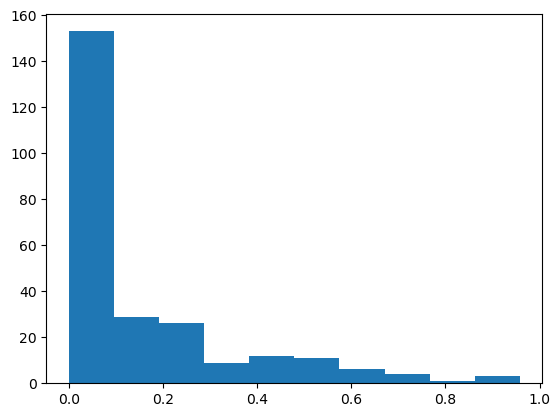

In [6]:
# Now let us refit the regressor on some selected features
# We can see that we have many more 'significant' results
selected = results.pvalues < 0.25
refitted_results = sm.OLS(y_train, X_train[:,selected]).fit()
refitted_results.summary()
print("p < 0.25:", sum(refitted_results.pvalues < 0.25))
print("p < 0.05:", sum(refitted_results.pvalues < 0.05))
plt.hist(refitted_results.pvalues)

We see that the selected features are now concentrated around 0.01. Indeed, if the p-values had not changed, we would expect to see a uniform distribution in the interval [0, 0.25]. However, refitting on those features created a new, non-uniform, p-value distribution.

Note that more clever libraries for feature selection may try to avoid this kind of bias by using holdout sets or cross validation. However, you should always test them using a method such as this: do they work as intended?

## Overfitting on the holdout set

It is even possible to overfit on the holdout set. We can do so by finding the best possible combination of features in terms of performance of the holdout set. Then we are *de facto* optimising something on the holdout set. Hence, any measurement we make there is going to be biased.

### The Dwork et al experiment

In their 2015 paper "Generalization in Adaptive Data Analysis and Holdout Reuse", the authors describe the following procedure:

For each feature $i$ and dataset $D \in \{D_H, D_T\}$ being either the holdout or training set, compute the feature correlation 
$w_i^D = \sum_{(x,y) \in D} x_i y$.

Then, select the features
$W = \{ i : w_i^{D_T} w_i^{D_H} > 0 \wedge |w_i^{D_T}| \geq 1/\sqrt{n} \wedge |w_i^{D_H}| \geq 1/\sqrt{n}$.

Of course, this is going to have a very good performance on the hold-out set, as it uses the hold-out labels directly.

### An alternative experiment

Here we can simply choose the model that is the best without full access to the holdout set, but just a measurement of its value.
We can simply choose the best combination of labels on the holdout set.

In [7]:
# First, rank the features in terms of p-values

prank = np.argsort(results.pvalues)  # first values have lowest p-values
max_features = 16 # select the top 10 features


In [8]:
from itertools import chain, combinations
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

feature_list = list(powerset(range(max_features)))[1:]

In [9]:
from sklearn.linear_model import LinearRegression
best_score = -np.inf
best_features = None
for features in feature_list:
    #print(np.array(features))
    # look through every feature combination of top features
    selected_features = prank[np.array(features)]
    #print("Feature tested:", selected_features)
    
    # Train on the selected features only
    X_sel = X_train[:, selected_features]
    reg = LinearRegression().fit(X_sel, y_train)
    
    # Measure performance on the test set
    X_test_sel = X_test[:, selected_features]
    score = reg.score(X_test_sel, y_test)
    
    #print("Test score: ", score)
    if (score > best_score):
        best_score = score
        best_features = selected_features
        X_eval_sel = X_eval[:, best_features]
        eval_score = reg.score(X_eval_sel, y_eval)
        print(score, eval_score, best_features)


-0.008750544172728913 -0.008575655957163697 [102]
0.0009629409864111427 -0.01899165023503313 [1]
0.001537007039985383 -0.020305424075194534 [  1 138]
0.0017525608755675215 -0.01993188945812574 [  1 976]
0.00338751707645768 -0.023160129411892383 [1 6]
0.003518561905483608 -0.02464227963015042 [  1 138   6]
0.004493200897625282 -0.024294792466452053 [  1 976   6]
0.004507930326798859 -0.025594949897281838 [  1 138 976   6]
0.00452394237101883 -0.024485201305598725 [  1 895 976   6]
0.00482416710713407 -0.024230850877432042 [  1 976   6 211]
0.004849800767265822 -0.02441920825292132 [  1 895 976   6 211]
0.004891213631982083 -0.030573319230467355 [  1 138 364 976   6 211]
0.0049105187463592825 -0.03080361286448441 [  1 138 364 895 976   6 211]
0.0049541521192163485 -0.03525571507683756 [  1 138 364 112 976   6 211]
0.00500404004729571 -0.03547695670802642 [  1 138 364 895 112 976   6 211]


In [10]:
X_sel = X_train[:, 0:10]
reg = LinearRegression().fit(X_sel, y_train)
  
# Measure performance on the test set
X_test_sel = X_test[:, 0:10]
reg.score(X_test_sel, y_test)


0.039429584334354395

In [11]:
# Measure performance on the eval set
